In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('./../')
import modules.modulesCorrectionFactorsAndPlots as MCF
import modules.modulesPopulationFitting as PF
import TwoStateKineticModel as KM2S
import PDA as PDA

## Probability Walk Through

We will use a simple example

In [2]:
_N = 50 # Number of steps in the cumulative frequency distribution of T1 
BD = 1 # length of burst
_k1 = 50
_kminus1 = 5 
E1min = 0.2
E2min = 0.8
_F = 100 # Flourescence of burst (used for binomial distribution)

# E bins
Ebins, EBinCentres, dBin = PF.getBins(-0.1,1.1,50)
db = Ebins[1]-Ebins[0]

In [3]:
# Get descrete p(T1) for this burst duration
_T1s, _T2s, _PT1s = KM2S.PTi_TwoState_at_del_t(_N, 
                                          BD, 
                                          k_1=_k1, 
                                          k_minus1=_kminus1, 
                                          cumsum = False, 
                                          debug = False)


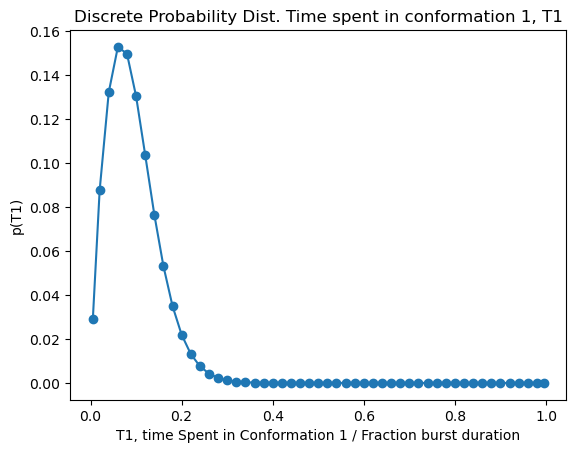

In [4]:
plt.plot(_T1s, _PT1s)
plt.scatter(_T1s, _PT1s)
plt.xlabel('T1, time Spent in Conformation 1 / Fraction burst duration')
plt.ylabel('p(T1)')
plt.title('Discrete Probability Dist. Time spent in conformation 1, T1')
# plt.savefig('./pT1.png')
plt.show()

In [5]:
 # get descrete p(E) for this burst duration 9length is N+1)
Esnf = KM2S.E_snf_TwoStatesEqualBrightness(_T1s, E1min, _T2s, E2min)

Note: This makes sense, molecule is _less_ likely to spend time in E1 from above so population is shifted towards E2

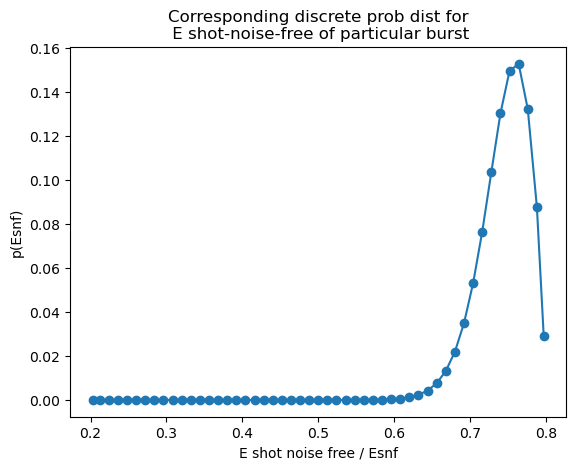

sum p(Esnf) = 1.0


In [6]:
plt.plot(Esnf, _PT1s)
plt.scatter(Esnf, _PT1s)
plt.xlabel('E shot noise free / Esnf')
plt.ylabel('p(Esnf)')
plt.title('Corresponding discrete prob dist for\n E shot-noise-free of particular burst')
# plt.savefig('./pEsnf.png')
plt.show()

# Check sum close to one
print(f'sum p(Esnf) = {_PT1s.sum():0.1f}')

# Gaussian

Experimental noise always larger than shot-noise, so each t value for time spent in E1 is actually a _distribution_ of Esnf values as E1, E2 are gaussian distributions

Need a double gaussian of E1, E2, always greater than experimental noise.

$$
E = \frac{1}{1+\big(\frac{r}{r_{0}}\big)^{6}}
$$

$$
r_{1/2} = r_{0}\cdot \big(\frac{1}{E_{1/2}} - 1\big)^{\frac{1}{6}}
$$

Calcualtes r1/2 with r0 = 50 Angstrom (ref, but can be varied to fit data)  

r1/2 is then sampled from a gaussian with sd 1.8 Angstrom (ref, but can be varied to fit data), which gives a gaussian distribution for Esnf for each Esnf value (i.e. each t value)  

In [7]:
calcR = lambda E, r0: r0*((1/E)-1)**(1/6)
rDev = 1.8
r0=50
continuousResolution = 10

calcE_from_r =  lambda r, r0: 1/(1+(r/r0)**6)

BOX IMMEDATELY BELOW ONLY NEEDS DONE ONCE PER EXPERIMENT 

**REVISIT SCALING**

In [8]:
# Get rs
r1 = calcR(E1min, r0)
r2 = calcR(E2min, r0)
print(f'r1: {r1:0.2f} A, r2: {r2:0.2f} A')

# Get distribution of rs
r1Norm = scipy.stats.norm(loc=r1, scale=rDev)
r2Norm = scipy.stats.norm(loc=r2, scale=rDev)

r1vals = np.linspace(r1Norm.ppf(0.01), r1Norm.ppf(0.99), continuousResolution)
r2vals = np.linspace(r2Norm.ppf(0.01), r2Norm.ppf(0.99), continuousResolution)

r1pdf = r1Norm.pdf(r1vals)/sum(r1Norm.pdf(r1vals)) # Normalising continuous -> Discrete
r2pdf = r2Norm.pdf(r2vals)/sum(r2Norm.pdf(r2vals)) # Normalising continuous -> Discrete

E1vals = calcE_from_r(r1vals, r0)
E2vals = calcE_from_r(r2vals,r0)

# Calculate the 2D distribution in E1, E2
# Important to note this gives (row, column) : (E1, E2)
#    --- E2 ---
#  | 
# E1
# |
E1E2dpdf = r1pdf[:, np.newaxis]*r2pdf

# Flattened matrix used later
E1E2dpdfflat = E1E2dpdf.flatten()

r1: 63.00 A, r2: 39.69 A


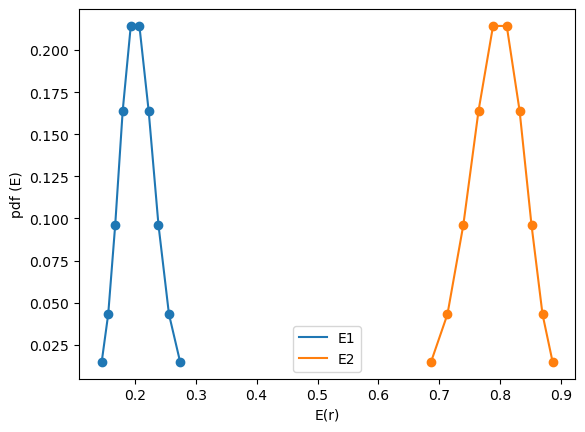

In [9]:
# # Plot distributions of r1, r2
# plt.plot(r1vals, r1pdf, label = 'r1')
# plt.plot(r2vals, r2pdf, label = 'r2')
# plt.ylabel('pdf')
# plt.xlabel('r')
# plt.legend()
# plt.show()

# Plot distributions of E1, E2
plt.plot(E1vals, r1Norm.pdf(r1vals), label = 'E1')
plt.plot(E2vals, r2Norm.pdf(r2vals), label = 'E2')
plt.scatter(E1vals, r1Norm.pdf(r1vals))
plt.scatter(E2vals, r2Norm.pdf(r2vals))
plt.ylabel('pdf (E)')
plt.xlabel('E(r)')
plt.legend()
plt.show()

### Single t _within_ a burst walkthrough

In [10]:
# Choose representative Sample
t_sample = 0.7 # np.random.choice(_T1s, 1)[0]
Esample = t_sample*E1min + (1-t_sample)*E2min
sampleBin, _, _ = scipy.stats.binned_statistic(Esample, Esample, statistic='count', bins=Ebins)

Calculate Esnfs(t1, E1, E2) for this t1, then correlate to p(E1, E2)

In [11]:
# Get 2D matrix of Esnf, for this t
T1E1s = t_sample*E1vals
T2E2s = (1-t_sample)*E2vals

# Some pythonic expressions, [:, np.newaxis] coerces TE vectors into 2D, tile duplicates row, then addition
# Again first vector transposed and duplicated, second isnt to ensure
#    --- E2 ---
#  | 
# E1
# |
# For re-combining with p(E1, E2)
# Equivilent to E.T * I + I * E2, Where I is identity matrix
Esnf2DGauss = np.tile(T1E1s[:, np.newaxis],continuousResolution) + np.tile(T2E2s,continuousResolution).reshape(continuousResolution, continuousResolution)

In [12]:
# Now we have a 2D matrix of Esnf values which MAPS to a 2D matrix of probabilities (for E1, E2 pairings)
# for the final Esnf distribution flatten each matrix and take the binned statistic sum of the probabilities (based on Esnf values)!
snfBinVals, _, _ = scipy.stats.binned_statistic(Esnf2DGauss.flatten(), values = E1E2dpdfflat, statistic='sum', bins=Ebins)
print(f'Final pmf close to 1? {sum(snfBinVals):0.2f}')

Final pmf close to 1? 1.00


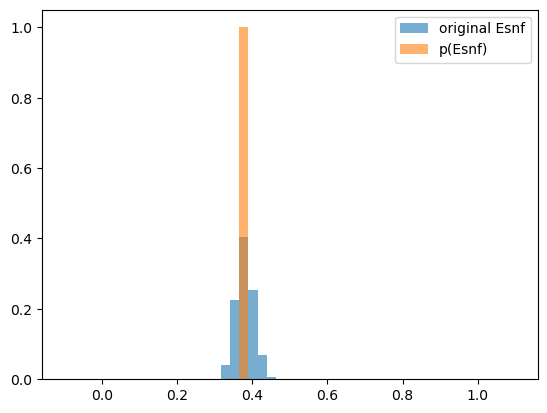

In [13]:
plt.bar(EBinCentres, snfBinVals, width=dBin, alpha=0.6, label = 'original Esnf')
plt.bar(EBinCentres, sampleBin, width=dBin, alpha=0.6, label = 'p(Esnf)')
plt.legend()
plt.show()

## _Every_ t value within this burst walkthrough

In [14]:
# Get all t1*E1s
# t1_Transpose * E1 => len(t) x len(E): (x,y)
t1E1 = _T1s[:, np.newaxis]*E1vals

# Get all t2*E2s
# t2Transpose * E2 => 3x5 (x,y)
t2E2 = _T2s[:, np.newaxis]*E2vals

# tile t1E1 in z: (slice, (row, column)) : (t, (t*E1, '*'))
t1E13Dz = np.repeat(t1E1[:, :, np.newaxis], repeats = continuousResolution, axis=2)

# tile t2E2 in z: (slice, (row, column)) : (t, ('*', t*E1))
t2E23Dz = np.repeat(t2E2[:, np.newaxis, :], repeats = continuousResolution, axis=1)

# Summing these 3D matrices gives t1E1 + t2E2 for all values of E1, E2, t1, t2 
# (slice, (row, column)) : (t, (t*E1, t*E2))
t1E1_plus_t2E2 = t1E13Dz + t2E23Dz

# Each (row, column) slice maps to the SAME 2D probability distribution p(E1, E2): (row, column) : (E1, E2), so need to extend this in x by len(t)
# (t, (E1, E2))
pE1E2z = np.repeat(E1E2dpdf[np.newaxis, :, :], repeats = len(_T1s), axis=0)

# Each slice (t) needs scaled by _original_ probability of that t, p(t)
pScaled_pE1E2z = _PT1s[:, np.newaxis, np.newaxis]*pE1E2z

# So we now have a 3D matrix for all E1, E2, t values, and a MAPPED 3D matrix for the scaled probability of that E1, E2, t combination
# Flattening each 3D matrix and binning yields the final p(Esnf)!t1E1_plus_t2E2.flatten()
pEsnf_Gauss, _, _ = scipy.stats.binned_statistic(x=t1E1_plus_t2E2.flatten(), values=pScaled_pE1E2z.flatten(), statistic='sum', bins=Ebins)

In [15]:
# Calculate original pEsnf for comparison
pEsnf_nonGauss, _, _ = scipy.stats.binned_statistic(x=Esnf, values=_PT1s, statistic='sum', bins=Ebins)

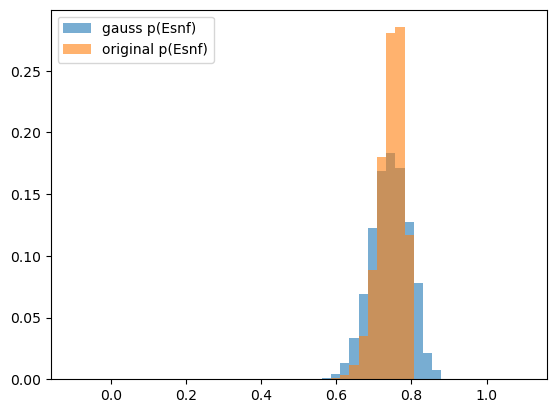

In [16]:
# Plot
plt.bar(EBinCentres, pEsnf_Gauss, width=dBin, alpha=0.6, label = 'gauss p(Esnf)')
plt.bar(EBinCentres, pEsnf_nonGauss, width=dBin, alpha=0.6, label = 'original p(Esnf)')
plt.legend()
plt.show()

# Now Combine with the rest of the treatment

Each descrete value of Esnf (Esnf_i) is binomially distributed about Esn_i, this gives the distribution of E shot noise (Esn_i).

Binomial distribution is determined by Flourescence and Esnf_i, 

F is the total photon count and Esnf_i is the probability of a photon count k (in F)

A photon count k corresponds to the acceptor photon count, Fr, and each Fr corresponds to a potential E shot noise

## Gaussian (Resolution) Difference:
Previously the Esnf was determined for each value of t1 but nowthe Esnf values have been binned to integrate the gaussian distribution, currently this binning is done to match final histogram but could be increased at this stage 

Not sure what to do? Ultimately this is resolution of comparison so maybe no need?

In [17]:
pEsn_givenEsnfAndF = lambda F, Esn: scipy.stats.binom(F, Esn)

In [18]:
# Returns a generator for each Esnf_i at flourescence F
pEsnDist = pEsn_givenEsnfAndF(_F, EBinCentres)

# Also calculate the corresponding Esn
Esn = np.array(range(0, _F+1))/_F

In [19]:
# Calculates the p(Esn) for each Fr (Red photon) in F 
# Note where Fr > F p(Esn) = 0 so appropriate to loop in this manner

EsnBinomials = np.zeros((_F+1, len(EBinCentres)))
for f in range(0, _F+1):
    EsnBinomials[f] = pEsnDist.pmf(f)

# returns an array where rows are Fg and columns are Esnf_i 

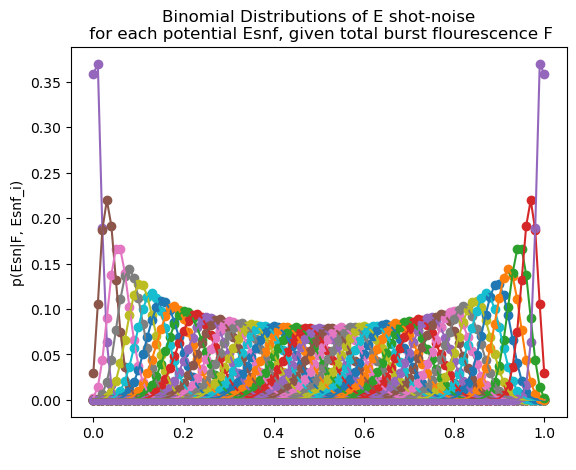

In [20]:
# Check Distribution looks sensible
for _pEsn in EsnBinomials.T:
    plt.plot(Esn, _pEsn)
    plt.scatter(Esn, _pEsn)
plt.xlabel('E shot noise')
plt.ylabel('p(Esn|F, Esnf_i)')
plt.title('Binomial Distributions of E shot-noise\n for each potential Esnf, given total burst flourescence F')
# plt.savefig('./binomialDistsEsn.png')
plt.show()

Each _individual_ p(Esn | F, Esnf_i) needs weighted by the original probability of Esnf_i (from gaussian processing above)

In [21]:
# Each column is a E_snf so matrix multiple by array of p(E_snf) to scale by p(Esn)
pWeightedEsn_i = EsnBinomials*pEsnf_Gauss

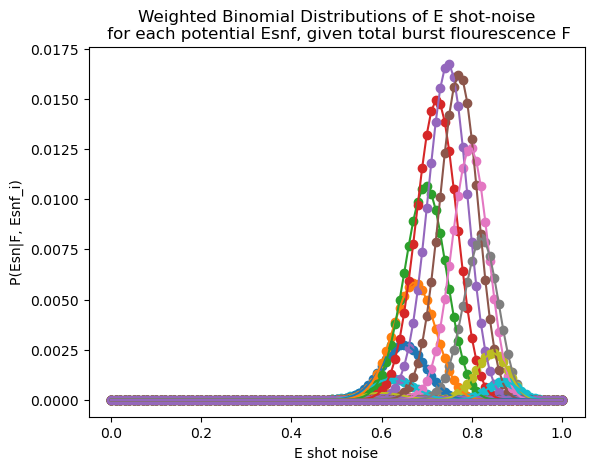

In [22]:
# Check Distribution looks sensible
for _pWeightedEsn in pWeightedEsn_i.T:
    plt.plot(Esn, _pWeightedEsn)
    plt.scatter(Esn, _pWeightedEsn)
plt.xlabel('E shot noise')
plt.ylabel('P(Esn|F, Esnf_i)')
plt.title('Weighted Binomial Distributions of E shot-noise\n for each potential Esnf, given total burst flourescence F')
# plt.savefig('./weightedBinomialDistsEsn.png')
plt.show()

In [23]:
# Sum each Esn for FINAL p(Esn)
pEsn = np.nansum(pWeightedEsn_i, axis=1)

# Check sum still close to 1
print(f'sum p(Esn) = {pEsn.sum():0.1f}')

# Binn values for comparison
pEsn_gauss, _, _ = scipy.stats.binned_statistic(x=Esn, values=pEsn, statistic='sum', bins=Ebins)

sum p(Esn) = 1.0


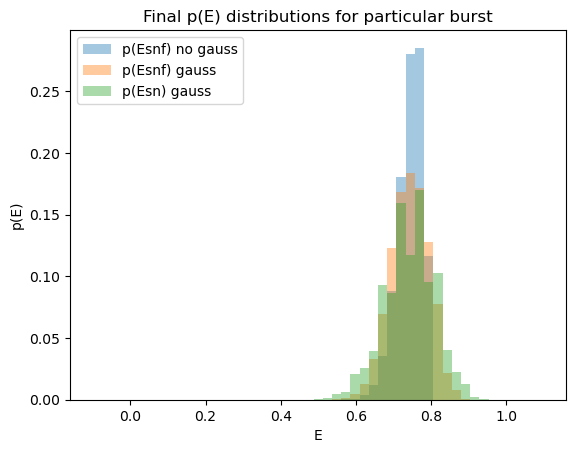

In [24]:
# Final comparison
# E shot noise free, no gaussian
plt.bar(EBinCentres, pEsnf_nonGauss, width=dBin, alpha=0.4, label = 'p(Esnf) no gauss')
# E shot noise free, gaussian
plt.bar(EBinCentres, pEsnf_Gauss, width=dBin, alpha=0.4, label = 'p(Esnf) gauss')
# E shot noise with gaussian
plt.bar(EBinCentres, pEsn_gauss, width=dBin, alpha=0.4, label = 'p(Esn) gauss')
plt.xlabel('E')
plt.ylabel('p(E)')
plt.legend()
plt.title('Final p(E) distributions for particular burst')
# plt.savefig('./pEsn.png')
plt.show()

### This then needs repeated for EVERY burst and pooled !!

In order to add p(Esn) values _between_ bursts a this probability histogram is used

# Test Gaussian Function work in PDA.py

In [25]:
gausEsnf_funcTest = PDA.getGaussianpEsnf_forBurst(PT1s=_PT1s, 
                                                  T1s=_T1s, 
                                                  T2s=_T2s, 
                                                  E1GaussianVals=E1vals, 
                                                  E2GaussianVals=E2vals, 
                                                  E1E2Gaussian2Dpdf=E1E2dpdf, 
                                                  gaussianResolution=continuousResolution, 
                                                  Ebins=Ebins)

gausEsn_funcTest = PDA.getEsn_FromEsnf_AndF(F=_F, 
                                            Esnf=EBinCentres, 
                                            EsnfWeights=gausEsnf_funcTest, 
                                            Ebins=Ebins)

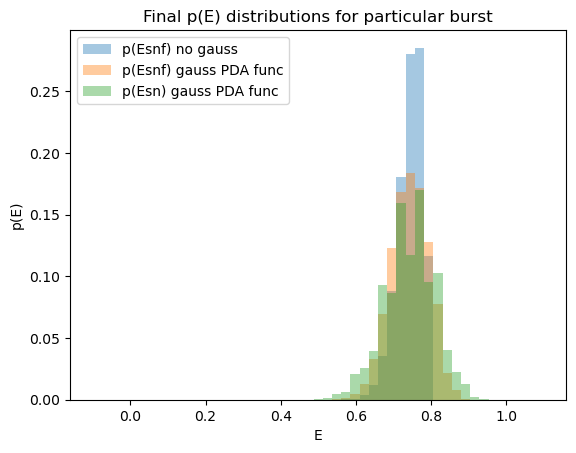

In [26]:
# E shot noise free, no gaussian
plt.bar(EBinCentres, pEsnf_nonGauss, width=dBin, alpha=0.4, label = 'p(Esnf) no gauss')
# E shot noise free, gaussian
plt.bar(EBinCentres, gausEsnf_funcTest, width=dBin, alpha=0.4, label = 'p(Esnf) gauss PDA func')
# E shot noise, gaussian
plt.bar(EBinCentres, gausEsn_funcTest, width=dBin, alpha=0.4, label = 'p(Esn) gauss PDA func')
plt.xlabel('E')
plt.ylabel('p(E)')
plt.legend()
plt.title('Final p(E) distributions for particular burst')
# plt.savefig('./pEsn.png')
plt.show()

Didn't expect that to work ...